In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
import time

# Declarar la semilla, para poder obtener los mismos resultados después de ejecutar el programa varias veces
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)


In [13]:
# PREPARAR EL CONJUNTO DE DATOS
def shuffle_in_unison(a,b):
    # Mezclar dos vectores del mismo modo
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [14]:
def load_data(ticker, n_steps = 50, scale = True, shuffle = True, lookup_step = 1, split_by_date = True, test_size = 0.2, feature_columns = ['adjclose','volume','open','high','low']):
    """
    Cargar datos de Yahoo Finance, así como escalar, mezclar, normalizar y dividir.
    Parámetros:
        ticker (str/pd.DataFrame): La cotización que se quiera cargar, ejemplos incluyen AAPL, TESL, etc. 
        n_steps (int): la longitud del historico de datos (ejemplo: tamaño de ventana) usado para predecir. Por defecto se usa 50
        scale (bool): si las escalas de los precios están entre 0 y 1, por defecto está a True
        shuffle (bool): si se mezcla el conjunto de datos (ambos el de entrenamiento y el de test), por defecto esta a True. 
        lookup_step (int): el próximo paso de búsqueda para realizar la predicción, el valor por defecto es 1 (sería para el siguiente dia)
        split_by_date (bool): si separamos el conjunto de datos en entrenamiento/test por fecha, definiéndolo como Falso los conjuntos se separaran de forma aleatoria
        test_size (float): ratio para los datos de test, por defecto se usará 0.2 (20% serán datos de test)
        feature_columns (list): la lista de caracteristicas que se usará como input del modelo. Como predeterminado, se usarán todos los datos extraídos de Yahoo Finance
    """

    # Se comprueba si la cotización ya se ha extraído previamente de Yahoo Finance
    if isinstance(ticker, str):
        # Lo extraemos de Yahoo Finance
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # Ya se ha extraído, utilizar directamente
        df = ticker
    else:
        raise TypeError("La variable ticker puede ser tanto u string como un 'pd.DataFrame'")
    
    # La siguiente variable contendrá todos los elementos que queremos devolver de esta funcion
    result = {}
    # Devolveremos también el DataFrame original
    result['df'] = df.copy()
    # Nos debemos asegurar que la variable feature_columns exista dentro del dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' no existe en el dataframe."
    # Añadir en una nueva columna la fecha
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # Escalar los datos (los precios) entre 0 y 1 
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis = 1))
            column_scaler[column] = scaler
        # Añadir los casos de MinMaxScaler a la variable de salida
        result["column_scaler"] = column_scaler
    # Añadir la columna "objetivo" (etiquetas) desplazando un número = a lookup_step
    df['future'] = df['adjclose'].shift(-lookup_step)
    # La última columna de lookup_steps contendrá los valores NaN en la columna de future. Si se quisieran predecir 15 stocks, habría 15 columnas NaN
    # Almacenamos las columnas antes de desecharlas
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # Desechamos los NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # Obtener la última secuencia (last_sequence) indexando los últimos n_step junto con los lookup_step
    # Por ejemplo: si n_steps= 50 y lookup_step = 10, last_sequence debería ser 60
    # Esta última secuencia será utilizada para realizar la predicción de los precios de futuros stocks que no están disponibles en los datos que tenemos actualmente
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # Lo añadimos a la variable resultado
    result['last_sequence'] = last_sequence
    # Construimos las X y las y
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # Lo convertimos a vectores de tipo numpy
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # Separamos el conjunto de datos en grupo de entrenamiento y de test según su fecha (la otra forma es separarlos de forma aleatoria)
        train_samples = int((1 - test_size)*len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"] = X[train_samples:]
        result["y_test"] = y[train_samples:]
        if shuffle:
            # Mezclamos los conjuntos de datos para su entrenamiento (si shuffle esta activado)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:
        # Separamos el conjunto de datos de forma aleatoria
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size = test_size, shuffle = shuffle)
    # Obtenemos una lista con las fechas de los datos dentro del grupo de test
    dates = result["X_test"][:, -1, -1]
    # Recuperar las características de test del dataframe original
    result["test_df"] = result["df"].loc[dates]
    # Borrar fechas duplicadas en el dataframe de test
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # Borrar fechas de los conjuntos de entrenamiento y de test y los convertimos a float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [15]:
# CREACION DEL MODELO
def create_model(sequence_length, n_features, units = 256, cell = LSTM, n_layers = 2, dropout = 0.3, loss = "mean_absolute_error", optimizer = "rmsprop", bidirectional = False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # Primera capa
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = True), batch_input_shape = (None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences = True, batch_input_shape = (None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # Ultima capa
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = False)))
            else:
                model.add(cell(units, return_sequences = False))
        else: 
            # Capas escondidas
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences = True)))
            else:
                model.add(cell(units, return_sequences = True))
        # Añadir fallo después de cada capa
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [16]:
# ENTRENAMIENTO DEL MODELO
# Declaramos el tamaño de la secuencia (tamaño de la ventana)

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 350
# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [17]:
# Nos aseguramos de que los ficheros de resultados, logs y datos existen antes de entrenar el modelo
# Creamos los ficheros si no existen
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")


In [18]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)


Epoch 1/350
75/75 [==============================] - 27s 321ms/step - loss: 0.0016 - mean_absolute_error: 0.0248 - val_loss: 2.0402e-04 - val_mean_absolute_error: 0.0108

Epoch 00001: val_loss improved from inf to 0.00020, saving model to results\2021-06-21_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
Epoch 2/350
75/75 [==============================] - 19s 258ms/step - loss: 4.2823e-04 - mean_absolute_error: 0.0139 - val_loss: 2.7973e-04 - val_mean_absolute_error: 0.0122

Epoch 00002: val_loss did not improve from 0.00020
Epoch 3/350
75/75 [==============================] - 19s 248ms/step - loss: 4.8938e-04 - mean_absolute_error: 0.0158 - val_loss: 2.0990e-04 - val_mean_absolute_error: 0.0092

Epoch 00003: val_loss did not improve from 0.00020
Epoch 4/350
75/75 [==============================] - 19s 249ms/step - loss: 4.2862e-04 - mean_absolute_error: 0.0141 - val_loss: 1.8216e-04 - val_mean_absolute_error: 0.0087

Epoch 00004: val_loss improved from 

In [10]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir="logs"

Launching TensorBoard...

In [19]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [20]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [21]:
def predict(model, data):
    # Extraer la última secuencia de nuestros datos
    last_sequence = data["last_sequence"][-N_STEPS:]

    # Aumentar la dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)

    # Obtener la prediccion en una escala de 0 a 1
    prediction = model.predict(last_sequence)

    # Obtener el precio (invirtiendo el escalado)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [22]:
# Ya se puede evaluar nuestro modelo
# Para empezar, cargaremos los valores óptimos que se han guardado en la carpeta de resultados
model_path = os.path.join("results", model_name)+".h5"
model.load_weights(model_path)

In [23]:
# Calculamos el valor de loss y mean absolute error
# Evaluamos el modelo
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

# Calculamos el mean absolute error (haciendo un escalado inverso)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [24]:
# Ahora utilizaremos la funcion get_final_df para obtener el conjunto de datos de test y poder hacer predicciones sobre el
final_df = get_final_df(model, data)

# Predicción de los precios futuros
future_price = predict(model, data)

In [25]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [26]:
# Imprimimos los resultados

print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)
print("\n")
print(final_df)

Future price after 15 days is 3253.07$
huber_loss loss: 9.620676428312436e-05
Mean Absolute Error: 25.343246624034546
Accuracy score: 0.5462114904246461
Total buy profit: 14020.716999053955
Total sell profit: 2068.9164395332327
Total profit: 16089.633438587189
Profit per trade: 13.396863812312397


                   open         high          low        close     adjclose  \
1997-08-06     2.208333     2.312500     2.187500     2.250000     2.250000   
1997-08-07     2.250000     2.260417     2.125000     2.177083     2.177083   
1997-08-18     2.052083     2.052083     1.968750     2.041667     2.041667   
1997-08-19     2.093750     2.208333     2.052083     2.166667     2.166667   
1997-08-21     2.135417     2.171875     2.072917     2.114583     2.114583   
...                 ...          ...          ...          ...          ...   
2021-04-28  3434.800049  3489.879883  3425.000000  3458.500000  3458.500000   
2021-04-30  3525.120117  3554.000000  3462.500000  3467.419922  3467

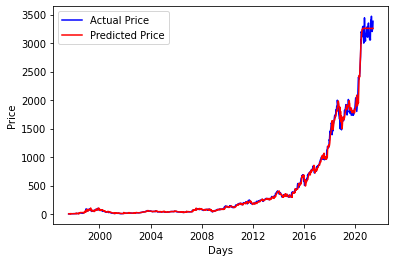

In [27]:
# Dibujar la gráfica
plot_graph(final_df)

In [60]:
import sqlite3
engine = create_engine('sqlite:///stock_info.db', echo=True)
sqlite_connection = engine.connect()
sqlite_table = "stocks"
final_df.to_sql(sqlite_table, sqlite_connection, if_exists='fail')

2021-06-22 19:47:36,733 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("stocks")
2021-06-22 19:47:36,734 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-22 19:47:36,736 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("stocks")
2021-06-22 19:47:36,736 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-22 19:47:36,739 INFO sqlalchemy.engine.Engine 
CREATE TABLE stocks (
	"index" DATETIME, 
	open FLOAT, 
	high FLOAT, 
	low FLOAT, 
	close FLOAT, 
	adjclose FLOAT, 
	volume BIGINT, 
	ticker TEXT, 
	adjclose_15 FLOAT, 
	true_adjclose_15 FLOAT, 
	buy_profit FLOAT, 
	sell_profit FLOAT
)


2021-06-22 19:47:36,740 INFO sqlalchemy.engine.Engine [no key 0.00148s] ()
2021-06-22 19:47:36,763 INFO sqlalchemy.engine.Engine COMMIT
2021-06-22 19:47:36,765 INFO sqlalchemy.engine.Engine CREATE INDEX ix_stocks_index ON stocks ("index")
2021-06-22 19:47:36,766 INFO sqlalchemy.engine.Engine [no key 0.00096s] ()
2021-06-22 19:47:36,777 INFO sqlalchemy.engine.Engine COMMIT
2021-06-22 19:47:36,783 

In [42]:
sqlite_connection.close()

NameError: name 'sqlite3' is not defined